# Cartographie des accidents 🗺️🚗

## <font color="#f79646"> Résumé du script 📜 </font>
Nous vous proposons d'étudier les accidents sur une commune.
La période étudiée est de 10ans (2012-2022), permattant ainsi, une approche englobante.    

Après un nettoyage de la donnée et un assemblage des tables, vous aurez en sorti :
- des graphiques :
  - exploration de la donnée,
  - Evolution du nombre d'accident par année à l'échelle nationale
  - Evolution des accidents sur la commune
  - Evolution du nombre d'accident suivant le type de véhicule
  - Relation entre les types de véhicule et les dégats humains (2012-2022)
  
- des cartes :
  - La localisation générale des accidents,
  - Les accidents provoquant une hospitalisation ou une mort,
  - Les accidents où les personnes indemnes sont le plus présentes,
  - Des spatialisations suivant le type de véhicules impliqués :
    - Véhicules Personels Légérs,
    - Vélos et EDP à moteurs.



## <font color="#f79646"> Description de le base de donnée sur les accidents</font>

<p align="justify">
Les accidents corporels liés à la circulation routière sont des accidents ayant au moins provoqué une victime et impliquant au moins un véhicule (Arrêté du 27 mars 2007 relatif aux conditions d'élaboration des statistiques relatives aux accidents corporels de la circulation). Ces accidents sont répertoriés dans une base de données en accès libre créée par le Ministère de l'Intérieur et des Outre-Mer et administrée par l’Observatoire national interministériel de la sécurité routière "ONISR" depuis 2005. La base de données est annuelle et disponible sur le territoire français. Elle est composée de quatre fichiers comportant des informations sur les caractéristiques, les lieux, les usagers et les véhicules reliés à un accident.

[Bases de données annuelles des accidents corporels de la circulation routière - Années de 2005 à 2022](https://www.data.gouv.fr/fr/datasets/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2022/)

</p>


## <font color="#f79646"> Fonctionnement et adaptation suivant les besoins </font>

Notre script est modulable, permettant ainsi, de changer la commune de travail. Il faut rentrer le [code insee](https://www.insee.fr/fr/information/6800675) de la commune dans le premier bloc de code.

## <font color="#f79646"> Méthode </font>


### <font color="#f79646"> Cartographie </font>
<p align="justify">
Les données ont été agrégé à chaque troncon de route issu d'OSM. Ensuite, les tronçons de route ont été segmenté tous les 20 mettres. L'objectif étant de représenter des cercles proportionnels suivant le nombre d'accidents. De plus, les données ont été recatégoriser pour séparer les personnes indemmnes et celles bléssé et tués. D'autre part nous avons mis des filtres sur les types de véhicules.
</p>

#Choix de la commune sur laquelle on veut travailler 📍

Rentrer le [code insee](https://www.insee.fr/fr/information/6800675) de la commune sur laquelle vous souhaitez travailler.

In [ ]:
#Rentrer le code de la commune sur laquelle on veut travailler
code_commune = '35238'

#Configuration environnement de travail 🛠️

In [ ]:
#Initialisation de l'environnement avec geopandas
!apt update
!apt install gdal-bin python-gdal python3-gdal
# Install rtree - Geopandas requirment
!apt install python3-rtree
# Install Geopandas
!pip install geopandas
# Install Fiona
!pip install Fiona
# Instal contextily (fonds de carte)
!pip install contextily
# Install mapclassify (cartographie thématique)
!pip install mapclassify
#Depuis sa version 0.8, Geopandas peut fonctionner de manière expérimental avec Pygeos ce qui accèlère certaines opérations
!pip install pygeos
# Pour la cartographie interactive
!pip install folium
# Install scalebar
!pip install matplotlib_scalebar
# Install osmnx
!pip install osmnx
# Install sankey pour le graphique alluviale
!pip install pySankey


Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,756 kB]
Fetched 1,985 kB in 3s (646 kB/s)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
50 packages can be upgraded. 

In [ ]:
#Importation des librairies nécessaires
import pandas as pd #Gestion de données
import matplotlib.pyplot as plt #Visualisation de données
import matplotlib.colors as mcolors #Palettes de couleurs
import geopandas as gpd #Gestion données spatiales
import pygeos #Opérations sur les géométrie de données spatiales
import contextily as ctx #Fonds de carte
import fiona as np #lecture et écriture de données spatiales
import numpy as np #Manipulation de tableaux
import shapely #Manipulation de géométrie
import folium #Cartographie interactive
import mapclassify #Cartographie thématique
from matplotlib_scalebar.scalebar import ScaleBar #Echelle cartographique
import osmnx as ox #Données OSM
from shapely.geometry import LineString
import holoviews as hv
import plotly.graph_objects as go #pour les graphiques
from pySankey.sankey import sankey #pour le graphique alluviale

#Import des données 🔗

##Données sur les accidents 🚗

In [ ]:
#Téléchargement des datas depuis l'opendata (https://www.data.gouv.fr/fr/datasets/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2022/)
!wget -O usagers22.csv https://www.data.gouv.fr/fr/datasets/r/62c20524-d442-46f5-bfd8-982c59763ec8
!wget -O usagers21.csv https://www.data.gouv.fr/fr/datasets/r/ba5a1956-7e82-41b7-a602-89d7dd484d7a
!wget -O usagers20.csv https://www.data.gouv.fr/fr/datasets/r/78c45763-d170-4d51-a881-e3147802d7ee
!wget -O usagers19.csv https://www.data.gouv.fr/fr/datasets/r/36b1b7b3-84b4-4901-9163-59ae8a9e3028
!wget -O usagers18.csv https://www.data.gouv.fr/fr/datasets/r/72b251e1-d5e1-4c46-a1c2-c65f1b26549a
!wget -O usagers17.csv https://www.data.gouv.fr/fr/datasets/r/07bfe612-0ad9-48ef-92d3-f5466f8465fe
!wget -O usagers16.csv https://www.data.gouv.fr/fr/datasets/r/e4c6f4fe-7c68-4a1d-9bb6-b0f1f5d45526
!wget -O usagers15.csv https://www.data.gouv.fr/fr/datasets/r/b43a4237-9359-4217-b833-8d3dc29a6c24
!wget -O usagers14.csv https://www.data.gouv.fr/fr/datasets/r/457c10ff-ea6c-4238-9af1-d8dc62b896d4
!wget -O usagers13.csv https://www.data.gouv.fr/fr/datasets/r/af4349c5-0293-4639-8694-b8b628bfc6c3
!wget -O usagers12.csv https://www.data.gouv.fr/fr/datasets/r/a19e060e-1c18-4272-ac4e-d4745ab8fade
!wget -O vehicules22.csv https://www.data.gouv.fr/fr/datasets/r/c9742921-4427-41e5-81bc-f13af8bc31a0
!wget -O vehicules21.csv https://www.data.gouv.fr/fr/datasets/r/0bb5953a-25d8-46f8-8c25-b5c2f5ba905e
!wget -O vehicules20.csv https://www.data.gouv.fr/fr/datasets/r/a66be22f-c346-49af-b196-71df24702250
!wget -O vehicules19.csv https://www.data.gouv.fr/fr/datasets/r/780cd335-5048-4bd6-a841-105b44eb2667
!wget -O vehicules18.csv https://www.data.gouv.fr/fr/datasets/r/b4aaeede-1a80-4d76-8f97-543dad479167
!wget -O vehicules17.csv https://www.data.gouv.fr/fr/datasets/r/d6103d0c-6db5-466f-b724-91cbea521533
!wget -O vehicules16.csv https://www.data.gouv.fr/fr/datasets/r/be2191a6-a7cd-446f-a9fc-8d698688eb9e
!wget -O vehicules15.csv https://www.data.gouv.fr/fr/datasets/r/3420157e-7d23-4832-a710-a3a2f2df909c
!wget -O vehicules14.csv https://www.data.gouv.fr/fr/datasets/r/86c64436-427f-4042-a4ee-ed0aa31bac76
!wget -O vehicules13.csv https://www.data.gouv.fr/fr/datasets/r/3c059a3c-4624-4513-b3a4-2b18c48dfd47
!wget -O vehicules12.csv https://www.data.gouv.fr/fr/datasets/r/48683290-0d4d-429a-8fb6-977887098d5d
!wget -O caracteristiques22.csv https://www.data.gouv.fr/fr/datasets/r/5fc299c0-4598-4c29-b74c-6a67b0cc27e7
!wget -O caracteristiques21.csv https://www.data.gouv.fr/fr/datasets/r/85cfdc0c-23e4-4674-9bcd-79a970d7269b
!wget -O caracteristiques20.csv https://www.data.gouv.fr/fr/datasets/r/07a88205-83c1-4123-a993-cba5331e8ae0
!wget -O caracteristiques19.csv https://www.data.gouv.fr/fr/datasets/r/e22ba475-45a3-46ac-a0f7-9ca9ed1e283a
!wget -O caracteristiques18.csv https://www.data.gouv.fr/fr/datasets/r/6eee0852-cbd7-447e-bd70-37c433029405
!wget -O caracteristiques17.csv https://www.data.gouv.fr/fr/datasets/r/9a7d408b-dd72-4959-ae7d-c854ec505354
!wget -O caracteristiques16.csv https://www.data.gouv.fr/fr/datasets/r/96aadc9f-0b55-4e9a-a70e-c627ed97e6f7
!wget -O caracteristiques15.csv https://www.data.gouv.fr/fr/datasets/r/185fbdc7-d4c5-4522-888e-ac9550718f71
!wget -O caracteristiques14.csv https://www.data.gouv.fr/fr/datasets/r/85dfe8c6-589f-4e76-8a07-9f59e49ec10d
!wget -O caracteristiques13.csv https://www.data.gouv.fr/fr/datasets/r/18b1a57a-57bf-4bf1-b9ee-dfa5a3154225
!wget -O caracteristiques12.csv https://www.data.gouv.fr/fr/datasets/r/b2518ec1-6529-47bc-9d55-40e2effeb0e7


#Importer CSV to dataframe
usagers22 = pd.read_csv("usagers22.csv", sep=';')
usagers21 = pd.read_csv("usagers21.csv", sep=';')
usagers20 = pd.read_csv("usagers20.csv", sep=';')
usagers19 = pd.read_csv("usagers19.csv", sep=';')
usagers18 = pd.read_csv("usagers18.csv", sep=',')
usagers17 = pd.read_csv("usagers17.csv", sep=',')
usagers16 = pd.read_csv("usagers16.csv", sep=',')
usagers15 = pd.read_csv("usagers15.csv", sep=',')
usagers14 = pd.read_csv("usagers14.csv", sep=',')
usagers13 = pd.read_csv("usagers13.csv", sep=',')
usagers12 = pd.read_csv("usagers12.csv", sep=',')

vehicules22 = pd.read_csv("vehicules22.csv", sep=';')
vehicules22.head(3)
vehicules21 = pd.read_csv("vehicules21.csv", sep=';')
vehicules20 = pd.read_csv("vehicules20.csv", sep=';')
vehicules19 = pd.read_csv("vehicules19.csv", sep=';')
vehicules18 = pd.read_csv("vehicules18.csv", sep=',')
vehicules17 = pd.read_csv("vehicules17.csv", sep=',')
vehicules16 = pd.read_csv("vehicules16.csv", sep=',')
vehicules15 = pd.read_csv("vehicules15.csv", sep=',')
vehicules14 = pd.read_csv("vehicules14.csv", sep=',')
vehicules13 = pd.read_csv("vehicules13.csv", sep=',')
vehicules12 = pd.read_csv("vehicules12.csv", sep=',')

caracteristiques22 = pd.read_csv("caracteristiques22.csv", sep=';')
caracteristiques22.head(3)
caracteristiques21 = pd.read_csv("caracteristiques21.csv", sep=';')
caracteristiques20 = pd.read_csv("caracteristiques20.csv", sep=';')
caracteristiques19 = pd.read_csv("caracteristiques19.csv", sep=';')
caracteristiques18 = pd.read_csv("caracteristiques18.csv", sep=',', encoding='ISO-8859-1')
caracteristiques17 = pd.read_csv("caracteristiques17.csv", sep=',', encoding='ISO-8859-1')
caracteristiques16 = pd.read_csv("caracteristiques16.csv", sep=',', encoding='ISO-8859-1')
caracteristiques15 = pd.read_csv("caracteristiques15.csv", sep=',', encoding='ISO-8859-1')
caracteristiques14 = pd.read_csv("caracteristiques14.csv", sep=',', encoding='ISO-8859-1')
caracteristiques13 = pd.read_csv("caracteristiques13.csv", sep=',', encoding='ISO-8859-1')
caracteristiques12 = pd.read_csv("caracteristiques12.csv", sep=',', encoding='ISO-8859-1')

--2024-04-30 08:21:14--  https://www.data.gouv.fr/fr/datasets/r/62c20524-d442-46f5-bfd8-982c59763ec8
Resolving www.data.gouv.fr (www.data.gouv.fr)... 37.59.183.93
Connecting to www.data.gouv.fr (www.data.gouv.fr)|37.59.183.93|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://static.data.gouv.fr/resources/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2021/20231005-094229/usagers-2022.csv [following]
--2024-04-30 08:21:15--  https://static.data.gouv.fr/resources/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2021/20231005-094229/usagers-2022.csv
Resolving static.data.gouv.fr (static.data.gouv.fr)... 37.59.183.93
Connecting to static.data.gouv.fr (static.data.gouv.fr)|37.59.183.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13013255 (12M) [text/csv]
Saving to: ‘usagers22.csv’

usagers22.csv       100%[===================>]  12.

##Données sur les communes

In [ ]:
#Ajout des communes de France
!wget -O communes.geojson https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/georef-france-commune/exports/geojson?lang=fr&timezone=Europe%2FBerlin

#Importer la couche des IRIS
communes = gpd.read_file("communes.geojson", encoding='utf-8')
communes.head(5)

--2024-04-30 08:22:53--  https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/georef-france-commune/exports/geojson?lang=fr
Resolving public.opendatasoft.com (public.opendatasoft.com)... 34.248.20.69, 34.249.199.226
Connecting to public.opendatasoft.com (public.opendatasoft.com)|34.248.20.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/json]
Saving to: ‘communes.geojson’

communes.geojson        [        <=>         ] 271.02M  5.80MB/s    in 85s     

2024-04-30 08:24:19 (3.20 MB/s) - ‘communes.geojson’ saved [284183156]



geo_point_2d  year reg_code  \
0  {'lon': 6.080498812220846, 'lat': 44.056633175...  2023     [93]   
1  {'lon': 5.823167584619715, 'lat': 44.019569849...  2023     [93]   
2  {'lon': 5.616017596751714, 'lat': 43.904162189...  2023     [93]   
3  {'lon': 6.1595420491675075, 'lat': 44.47161345...  2023     [93]   
4  {'lon': 6.36413066153131, 'lat': 45.0001691464...  2023     [93]   

                       reg_name dep_code                   dep_name  \
0  [Provence-Alpes-Côte d'Azur]     [04]  [Alpes-de-Haute-Provence]   
1  [Provence-Alpes-Côte d'Azur]     [04]  [Alpes-de-Haute-Provence]   
2  [Provence-Alpes-Côte d'Azur]     [04]  [Alpes-de-Haute-Provence]   
3  [Provence-Alpes-Côte d'Azur]     [05]             [Hautes-Alpes]   
4  [Provence-Alpes-Côte d'Azur]     [05]             [Hautes-Alpes]   

  arrdep_code        arrdep_name ze2020_code        ze2020_name  ...  \
0       [043]  [Digne-les-Bains]      [9307]  [Digne-les-Bains]  ...   
1       [044]      [Forcalquier]      [9311]         [Manosque]  ...   
2       [044]      [Forcalquier]      [9311]         [Manosque]  ...   
3       [052]              [Gap]      [9310]              [Gap]  ...   
4       [051]         [Briançon]      [9302]         [Briançon]  ...   

  com_cateaav2020_code                com_cateaav2020_name com_uu2020_code  \
0                   20              Commune de la couronne           04000   
1                   30  Commune hors attraction des villes           04000   
2                   20              Commune de la couronne           04000   
3                   20              Commune de la couronne           05000   
4                   30  Commune hors attraction des villes           05000   

    com_uu2020_status com_aav2020_code com_cv_code com_in_ctu com_siren_code  \
0  hors unité urbaine              251        0405        Non      210401220   
1  hors unité urbaine              000        0406        Non      210401642   
2  hors unité urbaine              275        0411        Non      210401758   
3  hors unité urbaine              119        0504        Non      210501151   
4  hors unité urbaine              000        0502        Non      210501813   

  com_is_mountain_area                                           geometry  
0                  Oui  POLYGON ((6.07515 44.09000, 6.07574 44.08869, ...  
1                  Oui  POLYGON ((5.84630 44.01306, 5.84490 44.01616, ...  
2                  Oui  POLYGON ((5.59021 43.88715, 5.59071 43.88724, ...  
3                  Oui  POLYGON ((6.16094 44.48387, 6.16059 44.48381, ...  
4                  Oui  POLYGON ((6.35817 44.94158, 6.35894 44.94182, ...  

[5 rows x 40 columns]

#Traitements des données 📁

##Traitement de la donnée accident 🚗

In [ ]:
#Définitions
#Agréger l'information sur la gravité
def redef_grav(gravite):
    if gravite == 1:
        return 'Indemne'
    elif gravite in (2, 3, 4):
        return 'Blessé / Tué'
    else:
        return 'Inconnu'

#Agréger l'information sur les catégories de véhicules
def redef_cat(categorie):
    if categorie in (7, 10):
        return 'Voiture'
    elif categorie in (2, 30, 31, 32, 33, 34):
        return 'Deux roues motorisées'
    elif categorie in (1, 50, 80):
        return 'Vélo / EDP à moteur'
    elif categorie in (13, 14, 15, 17, 37, 38):
        return 'Véhicule lourd'
    else:
        return 'Inconnu'


#Création d'une liste qui contient tous les fichiers de caracteristiques
dataframes_list = [caracteristiques12, caracteristiques13, caracteristiques14, caracteristiques15, caracteristiques16, caracteristiques17, caracteristiques18, caracteristiques19, caracteristiques20, caracteristiques21, caracteristiques22]

# Parcourir la liste des DataFrames
for i in range(len(dataframes_list)):
    # Vérifier si l'année correspond à 2012 à 2018
    if 2012 + i <= 2018:
        # Modifier les colonnes 'latitude' et 'longitude'
        dataframes_list[i]['lat'] = dataframes_list[i]['lat'] / 100000
        dataframes_list[i]['long'] = dataframes_list[i]['long'] / 100000

#Concaténer les DataFrames
caracteristiques = pd.concat(dataframes_list)

#Réécriture des latitudes et longitudes afin qu'ils soient lisibles par python
caracteristiques['x'] = caracteristiques['lat'].apply(lambda x: float(str(x).replace(',', '.')))
caracteristiques['y'] = caracteristiques['long'].apply(lambda y: float(str(y).replace(',', '.')))

# Supprimer les colonnes "lat" et "long"
caracteristiques = caracteristiques.drop(columns=['lat', 'long'])

#Regrouper les id uniques dans la colonne 'Num_Acc'
caracteristiques['Num_Acc'] = caracteristiques['Num_Acc'].fillna(caracteristiques['Accident_Id'])
caracteristiques.drop(columns=['Accident_Id'], inplace=True)
caracteristiques['Num_Acc'] = caracteristiques['Num_Acc'].astype(int)

#Création d'une liste qui contient tous les fichiers de caracteristiques
usagers_list = [usagers12, usagers13, usagers14, usagers15, usagers16, usagers17, usagers18, usagers19, usagers20, usagers21, usagers22]

#Concaténer les DataFrames
usagers = pd.concat(usagers_list)

#Jointure attributaire afin d'ajouter la gravité de l'accidents au geodataframe caracteristiques
caracteristiques = pd.merge(caracteristiques, usagers[['Num_Acc', 'grav']], how='inner', on='Num_Acc')

# Appliquer la fonction à la colonne 'grav' pour créer une nouvelle colonne 'gravite'
caracteristiques['gravite'] = caracteristiques['grav'].apply(redef_grav)

#Création d'une liste qui contient tous les fichiers de caracteristiques
vehicules_list = [vehicules12, vehicules13, vehicules14, vehicules15, vehicules16, vehicules17, vehicules18, vehicules19, vehicules20, vehicules21, vehicules22]

#Concaténer les DataFrames
vehicules = pd.concat(vehicules_list)
#Jointure attributaire afin d'ajouter la gravité de l'accidents au geodataframe caracteristiques
caracteristiques = pd.merge(caracteristiques, vehicules[['Num_Acc', 'catv']], how='inner', on='Num_Acc')

# Appliquer la fonction à la colonne 'catv' pour créer une nouvelle colonne 'categorie'
caracteristiques['categorie'] = caracteristiques['catv'].apply(redef_cat)

#Création du geodataframe
caracteristiques = gpd.GeoDataFrame(caracteristiques, geometry=gpd.points_from_xy(caracteristiques.y, caracteristiques.x))

# Définir la projection géographique du GeoDataFrame
caracteristiques = caracteristiques.set_crs("EPSG:4326")

##Traitement de la donnée sur les communes de France

In [ ]:
communesok = communes

# Permet d'ignorer les [] et transformer les objets en liste
communesok['com_code'] = communesok['com_code'].apply(lambda x: x[0])  # Suppose que chaque élément de la liste contient un seul nom de commune

# Sélectionner les lignes correspondant à la commune choisie
Ville = communesok.loc[communesok['com_code'] == code_commune]

# Jointure spatiale Accidents <> Ville
accidents = gpd.sjoin(caracteristiques, Ville[["geometry"]])

# Reprojection des couches
accidents = accidents.to_crs(2154)
# Suppression de la colonne index_right
accidents = accidents.drop(columns=['index_right'])

Dire comment les gens peuvent modifier notre script ici (mais le dire aussi dans l'intro avec la présentation du script)
code modulable suivant  la commune , le departement, la region
champs à modifier :


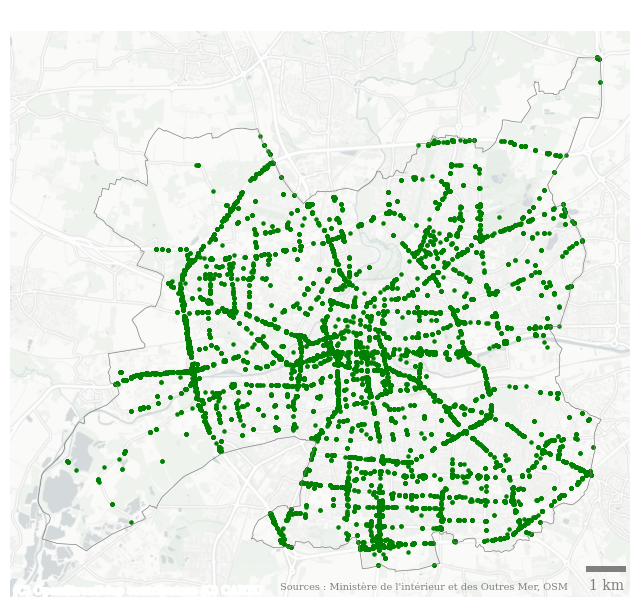

In [ ]:
# Tracer la carte
Carte1, ax = plt.subplots(figsize=(8,8)) # Propriétés de la carte

Ville.boundary.to_crs('EPSG:3857').plot(ax=ax, linewidth=0.5, color="grey")
accidents.to_crs('EPSG:3857').plot(ax=ax, marker='o', color='green', markersize=5)

# Ajout fond de carte
ctx.add_basemap(ax,source=ctx.providers.CartoDB.PositronNoLabels)
# On enlève les axes
ax.axis("off")
# Ajout du titre
plt.title("Accidents dans la commune")
#Ajout d'une échelle
ax.add_artist(ScaleBar(1, length_fraction=0.1, location = "lower right", box_alpha=0, color="grey"))
# Ajout des sources
ax.text(0.90, 0.01, "Sources : Ministère de l'intérieur et des Outres Mer, OSM", verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes, color='grey', fontsize=7)
plt.show()

## Traitement de la donnée sur les routes OSM 🚦

In [ ]:
# Extraire le polygone de Rennes
ville_polygon = Ville.geometry.iloc[0]

# Télécharger les données OSM pour le polygone de Rennes
graph = ox.graph_from_polygon(ville_polygon, network_type='drive')

# Créer un GeoDataFrame à partir des données du graphe OSM
routes = ox.graph_to_gdfs(graph, nodes=False, edges=True)

#Reprojection du GeoDataFrame
routes = routes.to_crs(2154)
Ville = Ville.to_crs(2154)

# Fonction pour découper une ligne en segments de longueur fixe
def cut_line(line, distance):
    if distance <= 0:
        return [line]
    if distance >= line.length:
        return [LineString(line)]
    coords = [(line.interpolate(i).x, line.interpolate(i).y) for i in range(0, int(line.length), distance)]
    segments = [LineString(coords[i:i+2]) for i in range(len(coords)-1)]
    return segments

# Définir la longueur de découpe (20 mètres dans ce cas)
cut_length = 20  # en mètres

# Liste pour stocker les nouveaux segments
new_segments = []

# Parcourir chaque ligne de routes et découper en segments de 20 mètres
for index, row in routes.iterrows():
    line = row['geometry']
    if isinstance(line, LineString):
        segments = cut_line(line, cut_length)
        new_segments.extend(segments)

# Créer un GeoDataFrame pour les nouveaux segments
routes_coupe = gpd.GeoDataFrame(geometry=new_segments, crs=routes.crs)

# Créer un tampon de 20 mètres autour de chaque segment de route
tampon_segments = routes_coupe.buffer(20)

# Créer un GeoDataFrame pour les tampons
tampon = gpd.GeoDataFrame(geometry=tampon_segments, crs=routes_coupe.crs)
tampon['Id_route'] = tampon.index

#Exploration des données 📊

## Evolution du nombre d'accident par année

### Evolution du nombre d'accident par année à l'échelle nationale

In [ ]:
# supposons que votre table est un dataframe nommé 'caracteristiques'
df = caracteristiques

# extraire les 4 premiers caractères de la colonne 'Num_Acc' pour obtenir l'année
df['an'] = df['Num_Acc'].astype(str).str.slice(0, 4)

# grouper les données par 'an', puis compter le nombre de 'Num_Acc' uniques pour chaque groupe
cara_grouped = df.groupby('an')['Num_Acc'].nunique()

# renommer les colonnes
cara_grouped = cara_grouped.rename('nombre_num_accident_uniques')
cara_grouped = cara_grouped.reset_index()

# trier les données par 'an'
cara_grouped = cara_grouped.sort_values('an')

sommenat = cara_grouped['nombre_num_accident_uniques'].sum()

print(f"Nombre d'accidents à l'échelle nationale entre 2012 et 2022 : {sommenat}")

Nombre d'accidents à l'échelle nationale entre 2012 et 2022 : 635475


In [ ]:
# graphique evolution nationale
# Créer le graphique en ligne
fig = go.Figure()

# Ajouter une trace pour le nombre de 'Num_Acc' uniques par année
fig.add_trace(go.Scatter(x=cara_grouped['an'], y=cara_grouped['nombre_num_accident_uniques'], mode='lines', name='Nombre d\'accidents', line_color='#EDAE55'))

# Personnaliser l'apparence du graphique
fig.update_layout(
    title=(f"Évolution du nombre d'accidents par année à l'échelle nationale"),
    xaxis_title='Année',
    yaxis_title='Nombre d\'accidents uniques',
    plot_bgcolor='white',
    xaxis_gridcolor='lightgray',
    yaxis_gridcolor='lightgray',
    font=dict(family='Arial', size=14, color='grey'),
)

# Afficher le graphique
fig.show()


### Evolution des accidents sur la commune

In [ ]:
# supposons que votre table est un dataframe nommé 'caracteristiques'
df = accidents

# extraire les 4 premiers caractères de la colonne 'Num_Acc' pour obtenir l'année
df['an'] = df['Num_Acc'].astype(str).str.slice(0, 4)

# grouper les données par 'an', puis compter le nombre de 'Num_Acc' uniques pour chaque groupe
grouped = df.groupby('an')['Num_Acc'].nunique()

# renommer les colonnes
grouped = grouped.rename('nombre_num_accident_uniques')
grouped = grouped.reset_index()

# trier les données par 'an'
grouped = grouped.sort_values('an')

# afficher les données
# print(grouped)

# Calcul de la somme pour la colonne spécifique
somme = grouped['nombre_num_accident_uniques'].sum()

print(f"Nombre d'accidents dans la commune ({code_commune}) : {somme}")



Nombre d'accidents dans la commune (35238) : 3870


In [ ]:
# Créer le graphique en ligne
fig = go.Figure()

# Ajouter une trace pour le nombre de 'Num_Acc' uniques par année
fig.add_trace(go.Scatter(x=grouped['an'], y=grouped['nombre_num_accident_uniques'], mode='lines', name='Nombre d\'accidents', line_color='#EDAE55'))

# Personnaliser l'apparence du graphique
fig.update_layout(
    title=(f"Évolution du nombre d\'accidents par année dans la commune choisie ({code_commune})"),
    xaxis_title='Année',
    yaxis_title='Nombre d\'accidents',
    plot_bgcolor='white',
    xaxis_gridcolor='lightgray',
    yaxis_gridcolor='lightgray',
    font=dict(family='Arial', size=14, color='grey'),
)

# Afficher le graphique
fig.show()


### Evolution du nombre d'accident suivant le type de véhicule

In [ ]:
df = accidents

# extraire les 4 premiers caractères de la colonne 'Num_Acc' pour obtenir l'année
df['an'] = df['Num_Acc'].astype(str).str.slice(0, 4)

# grouper les données par 'an' et 'Categorie', puis compter le nombre de 'Num_Acc' uniques pour chaque groupe
grouped = df.groupby(['an', 'categorie'])['Num_Acc'].nunique().reset_index(name='nombre_num_accident_uniques')

# trier les données par 'an' et 'nombre_num_accident_uniques' dans l'ordre décroissant
grouped = grouped.sort_values(['an', 'nombre_num_accident_uniques'], ascending=[True, False])

# filtrez les données pour sélectionner uniquement les lignes correspondant à l'année 2012
grouped_2012 = grouped.loc[grouped['an'] == '2012']

# affichez les 5 premières lignes du dataframe filtré
grouped_2012.head()

an              categorie  nombre_num_accident_uniques
1  2012                Voiture                          304
0  2012  Deux roues motorisées                          125
3  2012    Vélo / EDP à moteur                           77
2  2012         Véhicule lourd                           23

In [ ]:
import plotly.express as px
# Définir les couleurs pour chaque catégorie
colors = {'Voiture': '#55B0ED', 'Deux roues motorisées': '#EDDA55', 'Vélo / EDP à moteur': '#55ED62', 'Véhicule lourd': '#ED7555', 'Inconnu': '#F5BAF3'}

# Créer le graphique en ligne area chart
fig = px.area(grouped, x='an', y='nombre_num_accident_uniques', color='categorie', color_discrete_map=colors)

# Personnaliser l'apparence du graphique
fig.update_layout(
    title=(f"Évolution du nombre de véhicules impliqués dans un accident suivant le type de véhicule dans la commune choisie ({code_commune})"),
    xaxis_title='Année',
    yaxis_title='Nombre de véhicules impliqués',
    plot_bgcolor='white',
    font=dict(family='Arial', size=14, color='grey')
)

# Afficher le graphique
fig.show()


## Relation entre les types de véhicule et les dégats humains (2012-2022)

In [ ]:
# Définir la correspondance entre les valeurs de grav et les libellés
grav_labels = {
    1: 'Indemne',
    2: 'Tué',
    3: "Blessé hospitalisé",
    4: "Blessé léger"
}

# Ajouter une nouvelle colonne à accidents en fonction des valeurs de grav
accidents['gravite_libelle'] = accidents['grav'].apply(lambda x: grav_labels.get(x, 'Valeur inconnue'))

# Définir la correspondance entre les valeurs de grav et les libellés
grav_croissant = {
    1: '1',
    2: '4',
    3: "3",
    4: "2"
}

# Ajouter une nouvelle colonne à accidents en fonction des valeurs de grav
accidents['gravite_croissant'] = accidents['grav'].apply(lambda x: grav_croissant.get(x, 'Valeur inconnue'))

# Afficher les 5 premières lignes du DataFrame pour vérifier que la colonne a été ajoutée
# accidents.head()

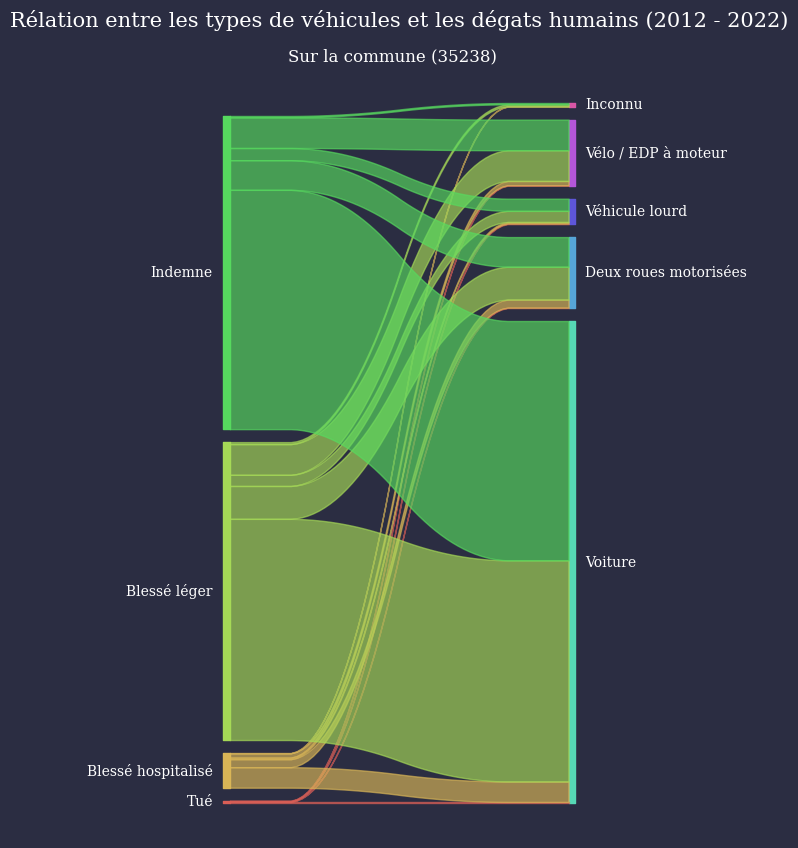

In [ ]:
# Réorganiser les données pour inverser l'ordre des catégories
accidents_sorted = accidents.sort_values(by="gravite_croissant", ascending=False)

# Créer le diagramme de Sankey avec les données réorganisées
sankey(
    left=accidents_sorted["gravite_libelle"],
    right=accidents_sorted["categorie"],
    aspect=20,
    fontsize=10
)

# Get current figure
fig = plt.gcf()

# Set size in inches
fig.set_size_inches(5, 10)

# Set the color of the background to white
fig.set_facecolor("#2b2d42")

#font color to white
plt.rcParams['text.color'] = 'white'

#font size to 12
plt.rcParams['font.size'] = 10

#Title
plt.title(f"Rélation entre les types de véhicules et les dégats humains (2012 - 2022)", fontsize=15, pad=30)
# #subtitle
plt.suptitle(f"Sur la commune ({code_commune})", fontsize=12, y=0.9)

fig.savefig("Graphique_Alluvial.png", bbox_inches="tight", dpi=800)

#Cartographies sur la base de donnée Accidents 🗺

##Les accidents provoquant une hospitalisation ou une mort

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.



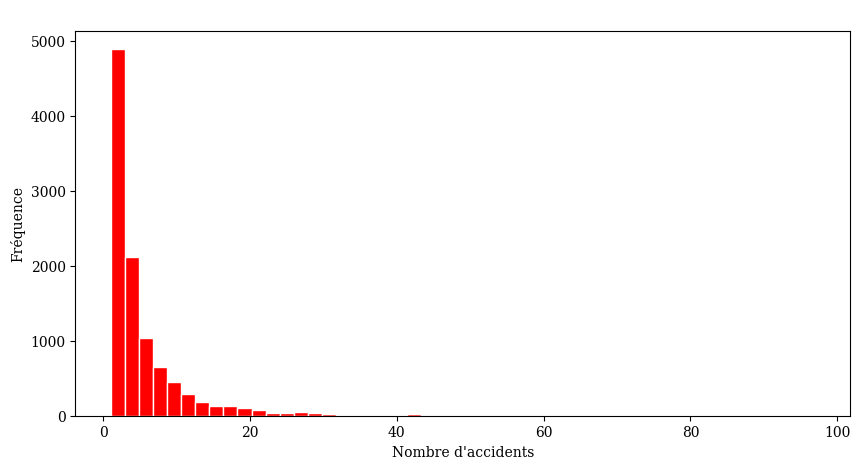

In [ ]:
# Filtrer les données où la victime est soit blessée soit morte
acc_blesses = accidents[(accidents['gravite'] == 'Blessé / Tué')]

# Jointure spatiale entre les accidents et les tampons
accble_in_buffers = gpd.sjoin(acc_blesses, tampon, how="inner", predicate="within")

# Calculer le  nombre d'accidents par tronçon de route
NbAccBle = accble_in_buffers[["Id_route", "Num_Acc"]].groupby("Id_route").size()
NbAccBle = pd.DataFrame(NbAccBle)
NbAccBle = NbAccBle.rename(columns={0: 'NbAccidents'})

# Supprimer les tronçons où il n'y a pas d'accidents
NbAccBle = NbAccBle[(NbAccBle['NbAccidents'] > 0)]

# Jointure attributaire pour repasser sur la couche des tronçons de route
tamponble = tampon.merge(NbAccBle, on='Id_route')

# Créer le graphique en ligne
fig = go.Figure()

# Ajouter une trace pour l'histogramme
fig.add_trace(go.Histogram(x=NbAccBle['NbAccidents'], marker_color="#DE5959", opacity=0.75))

# Personnaliser l'apparence du graphique
fig.update_layout(
    title="Histogramme du nombre d'accidents provoquant une hospitalisation ou une mort par tronçon de route",
    xaxis_title='Nombre d\'accidents',
    yaxis_title='Fréquence',
    plot_bgcolor='white',
    xaxis_gridcolor='lightgray',
    yaxis_gridcolor='lightgray',
    font=dict(family='Arial', size=14, color='grey'),
)

# Afficher l'histogramme
fig.show()

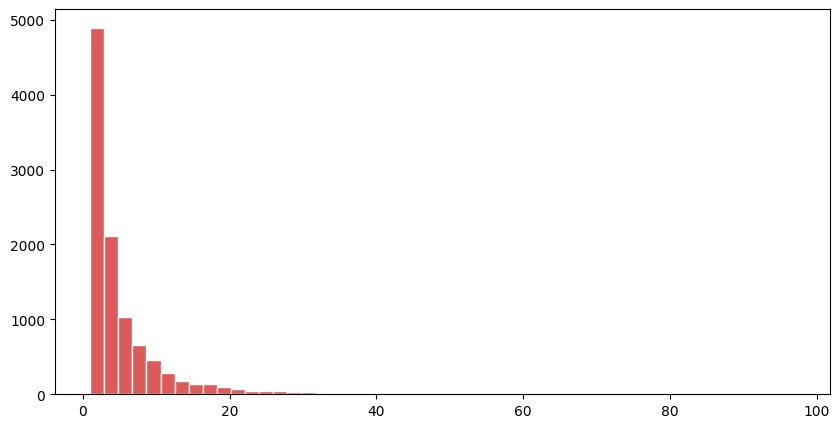

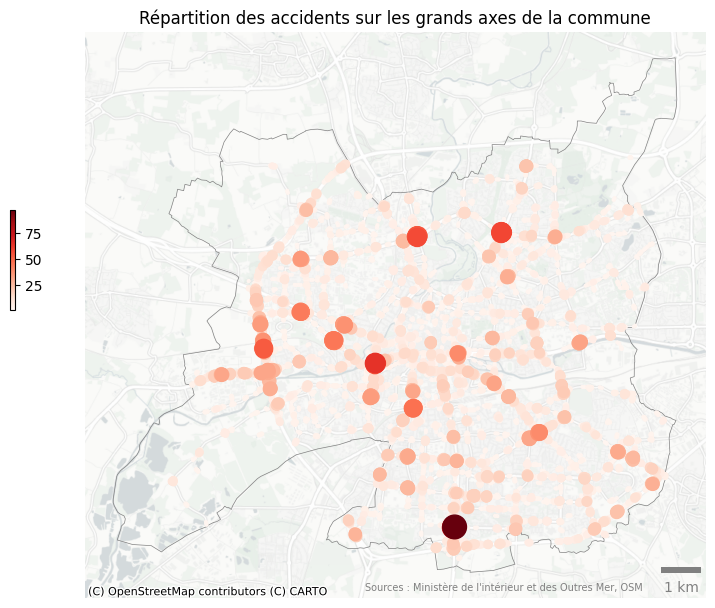

In [ ]:
# Créer des centroïds sur les tronçons de route
CentroBle = tamponble.copy()
CentroBle.geometry = CentroBle['geometry'].centroid

# Créer la figure et l'axe
Carte1, ax = plt.subplots(figsize=(13,13))
# Propriétés de la carte
Ville.boundary.to_crs('EPSG:3857').plot(ax=ax, linewidth=0.5, color="grey")
# Trier les données selon la colonne 'TailleAgrandie'
CentroBle = CentroBle.sort_values(by='NbAccidents', ascending=True)
# Convertir les coordonnées en EPSG 3857
CentroBle = CentroBle.to_crs(epsg=3857)

#Grossir les points
sizes = CentroBle['NbAccidents'] * 3

# Définir la colormap
cmap = plt.cm.Reds
# Normaliser les valeurs de NbAccidents pour les couleurs
norm = mcolors.Normalize(vmin=CentroBle['NbAccidents'].min(), vmax=CentroBle['NbAccidents'].max())

# Tracer les points avec scatter(), en utilisant NbAccidents pour la taille et la colormap pour la couleur
scatter = ax.scatter(CentroBle.geometry.x, CentroBle.geometry.y,
                     s=sizes, c=CentroBle['NbAccidents'], cmap=cmap, norm=norm, zorder=2)

# Ajouter une légende pour la colormap
cbar = plt.colorbar(scatter)
# Définir la position de la légende de la colormap
cbar.ax.set_position([0.05, 0.5, 0.02, 0.1])

# Ajouter fond de carte
ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels)
# Enlever les axes
ax.axis("off")
# Ajouter le titre
plt.title("Répartition des accidents sur les grands axes de la commune")
# Ajouter une échelle
ax.add_artist(ScaleBar(1, length_fraction=0.1, location="lower right", box_alpha=0, color="grey"))
# Ajouter les sources
ax.text(0.90, 0.01, "Sources : Ministère de l'intérieur et des Outres Mer, OSM", verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes, color='grey', fontsize=7)
plt.show()

##Les accidents indemnes

In [ ]:
# Filtrer les données où la victime est indemne
acc_indemnes = accidents[(accidents['gravite'] == 'Indemne')]

# Jointure spatiale entre les accidents et les tampons
accind_in_buffers = gpd.sjoin(acc_indemnes, tampon, how="inner", predicate="within")

# Calculer le  nombre d'accidents par tronçon de route
NbAccInd = accind_in_buffers[["Id_route", "Num_Acc"]].groupby("Id_route").size()
NbAccInd = pd.DataFrame(NbAccInd)
NbAccInd = NbAccInd.rename(columns={0: 'NbAccidents'})

# Supprimer les tronçons où il n'y a pas d'accidents
NbAccInd = NbAccInd[(NbAccInd['NbAccidents'] > 0)]

# Jointure attributaire pour repasser sur la couche des tronçons de route
tamponInd = tampon.merge(NbAccInd, on='Id_route')

# Créer le graphique en ligne
fig = go.Figure()

# Ajouter une trace pour l'histogramme
fig.add_trace(go.Histogram(x=NbAccInd['NbAccidents'], marker_color="#69C26F", opacity=0.75))

# Personnaliser l'apparence du graphique
fig.update_layout(
    title="Histogramme du nombre d'accidents ne provoquant aucun blessé par tronçon de route",
    xaxis_title='Nombre d\'accidents',
    yaxis_title='Fréquence',
    plot_bgcolor='white',
    xaxis_gridcolor='lightgray',
    yaxis_gridcolor='lightgray',
    font=dict(family='Arial', size=14, color='grey'),
)

# Afficher l'histogramme
fig.show()

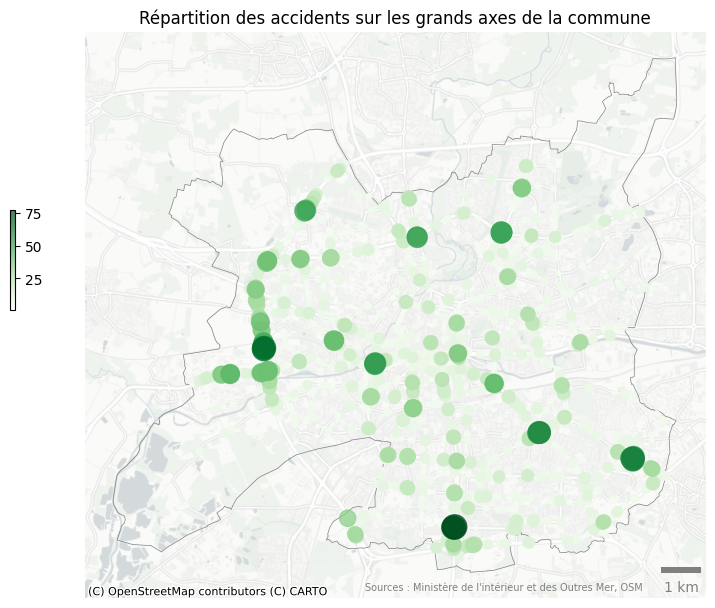

In [ ]:
# Créer des centroïds sur les tronçons de route
CentroInd = tamponInd.copy()
CentroInd.geometry = CentroInd['geometry'].centroid

# Créer la figure et l'axe
Carte1, ax = plt.subplots(figsize=(13,13))
# Propriétés de la carte
Ville.boundary.to_crs(epsg=3857).plot(ax=ax, linewidth=0.5, color="grey")
# Trier les données selon la colonne 'TailleAgrandie'
CentroInd = CentroInd.sort_values(by='NbAccidents', ascending=True)
# Convertir les coordonnées en EPSG 3857
CentroInd = CentroInd.to_crs(epsg=3857)

#Grossir les points
sizes = CentroInd['NbAccidents'] * 4

# Définir la colormap
cmap = plt.cm.Greens
# Normaliser les valeurs de NbAccidents pour les couleurs
norm = mcolors.Normalize(vmin=CentroInd['NbAccidents'].min(), vmax=CentroInd['NbAccidents'].max())

# Tracer les points avec scatter(), en utilisant NbAccidents pour la taille et la colormap pour la couleur
scatter = ax.scatter(CentroInd.geometry.x, CentroInd.geometry.y,
                     s=sizes, c=CentroInd['NbAccidents'], cmap=cmap, norm=norm, alpha=0.7, zorder=2)

# Ajouter une légende pour la colormap
cbar = plt.colorbar(scatter)
# Définir la position de la légende de la colormap
cbar.ax.set_position([0.05, 0.5, 0.02, 0.1])

# Ajouter fond de carte
ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels)
# Enlever les axes
ax.axis("off")
# Ajouter le titre
plt.title("Répartition des accidents sur les grands axes de la commune")
# Ajouter une échelle
ax.add_artist(ScaleBar(1, length_fraction=0.1, location="lower right", box_alpha=0, color="grey"))
# Ajouter les sources
ax.text(0.90, 0.01, "Sources : Ministère de l'intérieur et des Outres Mer, OSM", verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes, color='grey', fontsize=7)
plt.show()

##Les accidents pour véhicules personnels légers

In [ ]:
# Filtrer les données où la victime est dans un véhicule personnel léger
acc_voit = accidents[(accidents['categorie'] == 'Voiture')]

# Jointure spatiale entre les accidents et les tampons
accvoit_in_buffers = gpd.sjoin(acc_voit, tampon, how="inner", predicate="within")

# Calculer le  nombre d'accidents par tronçon de route
NbAccVoit = accvoit_in_buffers[["Id_route", "Num_Acc"]].groupby("Id_route").size()
NbAccVoit = pd.DataFrame(NbAccVoit)
NbAccVoit = NbAccVoit.rename(columns={0: 'NbAccidents'})

# Supprimer les tronçons où il n'y a pas d'accidents
NbAccVoit = NbAccVoit[(NbAccVoit['NbAccidents'] > 0)]

# Jointure attributaire pour repasser sur la couche des tronçons de route
tamponVoit = tampon.merge(NbAccVoit, on='Id_route')

# Créer le graphique en ligne
fig = go.Figure()

# Ajouter une trace pour l'histogramme
fig.add_trace(go.Histogram(x=NbAccVoit['NbAccidents'], marker_color="#579CCF", opacity=0.75))

# Personnaliser l'apparence du graphique
fig.update_layout(
    title="Histogramme du nombre d'accidents des véhicules personnels légers par tronçon de route",
    xaxis_title='Nombre d\'accidents',
    yaxis_title='Fréquence',
    plot_bgcolor='white',
    xaxis_gridcolor='lightgray',
    yaxis_gridcolor='lightgray',
    font=dict(family='Arial', size=14, color='grey'),
)

# Afficher l'histogramme
fig.show()

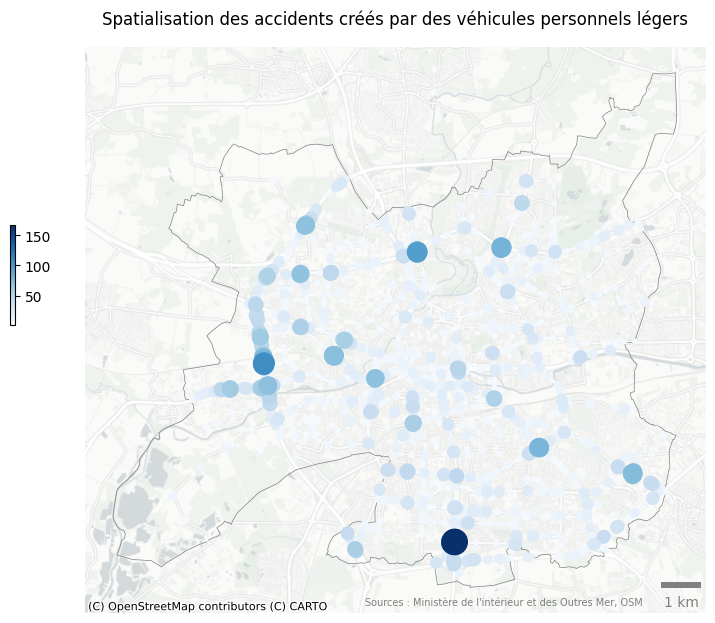

In [ ]:
# Créer des centroïds sur les tronçons de route
CentroVoit = tamponVoit.copy()
CentroVoit.geometry = CentroVoit['geometry'].centroid

# Créer la figure et l'axe
Carte1, ax = plt.subplots(figsize=(13,13))
# Propriétés de la carte
Ville.boundary.to_crs(epsg=3857).plot(ax=ax, linewidth=0.5, color="grey")
# Trier les données selon la colonne 'TailleAgrandie'
CentroVoit = CentroVoit.sort_values(by='NbAccidents', ascending=True)
# Convertir les coordonnées en EPSG 3857
CentroVoit = CentroVoit.to_crs(epsg=3857)

#Grossir les points
sizes = CentroVoit['NbAccidents'] * 2

# Définir la colormap
cmap = plt.cm.Blues
# Normaliser les valeurs de NbAccidents pour les couleurs
norm = mcolors.Normalize(vmin=CentroVoit['NbAccidents'].min(), vmax=CentroVoit['NbAccidents'].max())

# Tracer les points avec scatter(), en utilisant NbAccidents pour la taille et la colormap pour la couleur
scatter = ax.scatter(CentroVoit.geometry.x, CentroVoit.geometry.y,
                     s=sizes, c=CentroVoit['NbAccidents'], cmap=cmap, norm=norm, zorder=2)

# Ajouter une légende pour la colormap
cbar = plt.colorbar(scatter)
# Définir la position de la légende de la colormap
cbar.ax.set_position([0.05, 0.5, 0.02, 0.1])

# Ajouter fond de carte
ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels)
# Enlever les axes
ax.axis("off")
# Ajouter le titre
plt.title("Spatialisation des accidents créés par des véhicules personnels légers")
# Ajouter une échelle
ax.add_artist(ScaleBar(1, length_fraction=0.1, location="lower right", box_alpha=0, color="grey"))
# Ajouter les sources
ax.text(0.90, 0.01, "Sources : Ministère de l'intérieur et des Outres Mer, OSM", verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes, color='grey', fontsize=7)
plt.show()

##Les accidents pour vélos et EDP à moteur

In [ ]:
# Filtrer les données où la victime est dans un véhicule personnel léger
acc_velo = accidents[(accidents['categorie'] == 'Vélo / EDP à moteur')]

# Jointure spatiale entre les accidents et les tampons
accvelo_in_buffers = gpd.sjoin(acc_velo, tampon, how="inner", predicate="within")

# Calculer le  nombre d'accidents par tronçon de route
NbAccVelo = accvelo_in_buffers[["Id_route", "Num_Acc"]].groupby("Id_route").size()
NbAccVelo = pd.DataFrame(NbAccVelo)
NbAccVelo = NbAccVelo.rename(columns={0: 'NbAccidents'})

# Supprimer les tronçons où il n'y a pas d'accidents
NbAccVelo = NbAccVelo[(NbAccVelo['NbAccidents'] > 0)]

# Jointure attributaire pour repasser sur la couche des tronçons de route
tamponVelo = tampon.merge(NbAccVelo, on='Id_route')

# Créer le graphique en ligne
fig = go.Figure()

# Ajouter une trace pour l'histogramme
fig.add_trace(go.Histogram(x=NbAccVelo['NbAccidents'], marker_color="#C28423", opacity=0.75))

# Personnaliser l'apparence du graphique
fig.update_layout(
    title="Histogramme du nombre d'accidents par des vélos et EDP à moteur par tronçon de route",
    xaxis_title='Nombre d\'accidents',
    yaxis_title='Fréquence',
    plot_bgcolor='white',
    xaxis_gridcolor='lightgray',
    yaxis_gridcolor='lightgray',
    font=dict(family='Arial', size=14, color='grey'),
)

# Afficher l'histogramme
fig.show()

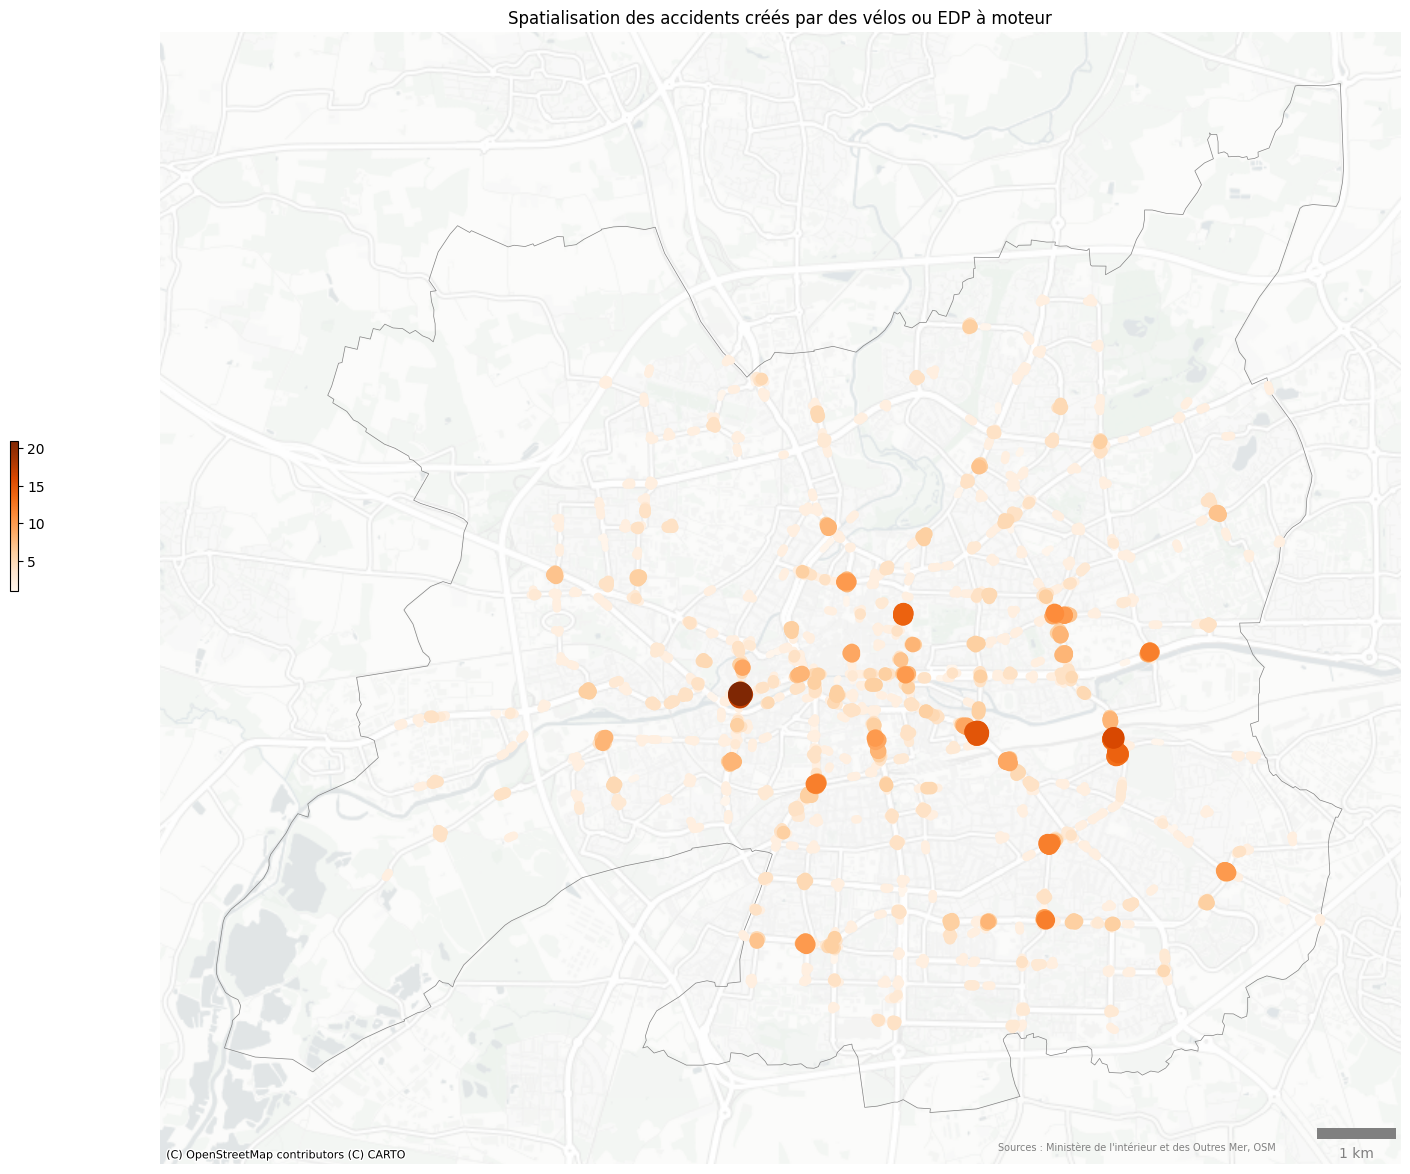

In [ ]:
# Créer des centroïds sur les tronçons de route
CentroVelo = tamponVelo.copy()
CentroVelo.geometry = CentroVelo['geometry'].centroid

# Créer la figure et l'axe
Carte1, ax = plt.subplots(figsize=(13,13))
# Propriétés de la carte
Ville.boundary.to_crs(epsg=3857).plot(ax=ax, linewidth=0.5, color="grey")
# Trier les données selon la colonne 'TailleAgrandie'
CentroVelo = CentroVelo.sort_values(by='NbAccidents', ascending=True)
# Convertir les coordonnées en EPSG 3857
CentroVelo = CentroVelo.to_crs(epsg=3857)

sizes = CentroVelo['NbAccidents'] * 13

# Définir la colormap
cmap = plt.cm.Oranges
# Normaliser les valeurs de NbAccidents pour les couleurs
norm = mcolors.Normalize(vmin=CentroVelo['NbAccidents'].min(), vmax=CentroVelo['NbAccidents'].max())

# Tracer les points avec scatter(), en utilisant NbAccidents pour la taille et la colormap pour la couleur
scatter = ax.scatter(CentroVelo.geometry.x, CentroVelo.geometry.y,
                     s=sizes, c=CentroVelo['NbAccidents'], cmap=cmap, norm=norm, zorder=2)

# Ajouter une légende pour la colormap
cbar = plt.colorbar(scatter)
# Définir la position de la légende de la colormap
cbar.ax.set_position([0.05, 0.5, 0.02, 0.1])

# Ajouter fond de carte
ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels, alpha = 0.7)
# Enlever les axes
ax.axis("off")
# Ajouter le titre
plt.title("Spatialisation des accidents créés par des vélos ou EDP à moteur")
# Ajouter une échelle
ax.add_artist(ScaleBar(1, length_fraction=0.1, location="lower right", box_alpha=0, color="grey"))
# Ajouter les sources
ax.text(0.90, 0.01, "Sources : Ministère de l'intérieur et des Outres Mer, OSM", verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes, color='grey', fontsize=7)
plt.show()

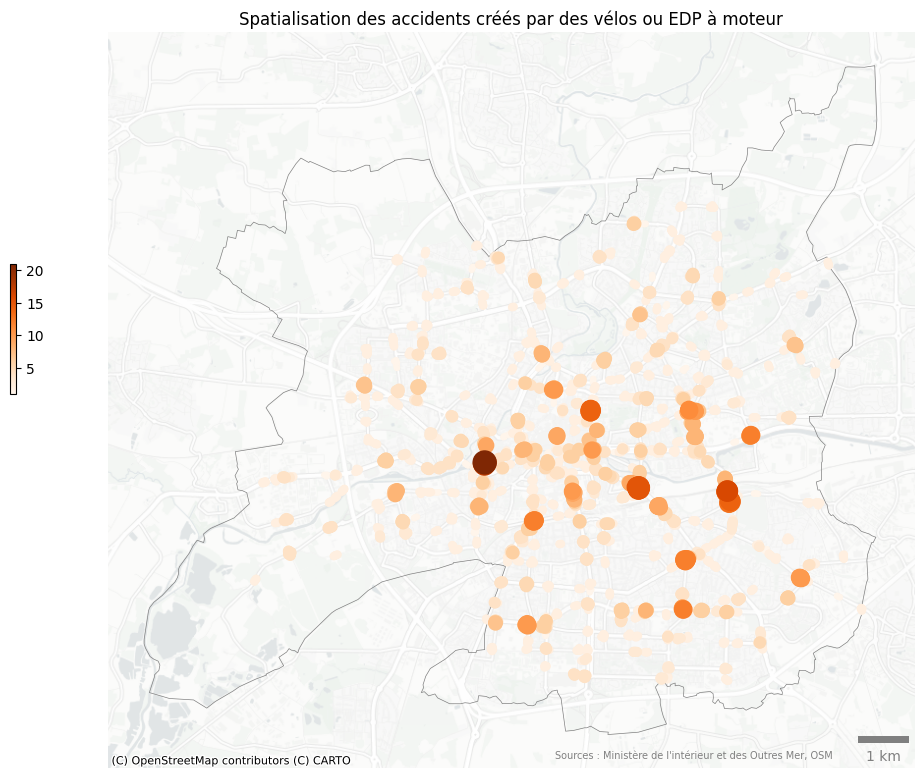

In [ ]:
# Créer la figure et l'axe
Carte1, ax = plt.subplots(figsize=(13,13))
# Propriétés de la carte
Ville.boundary.to_crs(epsg=3857).plot(ax=ax, linewidth=0.5, color="grey")
# Trier les données selon la colonne 'TailleAgrandie'
CentroVelo = CentroVelo.sort_values(by='NbAccidents', ascending=True)
# Convertir les coordonnées en EPSG 3857
CentroVelo = CentroVelo.to_crs(epsg=3857)

sizes = CentroVelo['NbAccidents'] * 13

# Définir la colormap
cmap = plt.cm.Oranges
# Normaliser les valeurs de NbAccidents pour les couleurs
norm = mcolors.Normalize(vmin=CentroVelo['NbAccidents'].min(), vmax=CentroVelo['NbAccidents'].max())

# Tracer les points avec scatter(), en utilisant NbAccidents pour la taille et la colormap pour la couleur
scatter = ax.scatter(CentroVelo.geometry.x, CentroVelo.geometry.y,
                     s=sizes, c=CentroVelo['NbAccidents'], cmap=cmap, norm=norm, zorder=2)

# Ajouter une légende pour la colormap
cbar = plt.colorbar(scatter)
# Définir la position de la légende de la colormap
cbar.ax.set_position([0.05, 0.5, 0.02, 0.1])

# Ajouter fond de carte
ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels, alpha = 0.7)
# Enlever les axes
ax.axis("off")
# Ajouter le titre
plt.title("Spatialisation des accidents créés par des vélos ou EDP à moteur")
# Ajouter une échelle
ax.add_artist(ScaleBar(1, length_fraction=0.1, location="lower right", box_alpha=0, color="grey"))
# Ajouter les sources
ax.text(0.90, 0.01, "Sources : Ministère de l'intérieur et des Outres Mer, OSM", verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes, color='grey', fontsize=7)
plt.show()